In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
%cd '/content/drive/My Drive/MindEye'
os.chdir('/content/drive/My Drive/MindEye')

/content/drive/My Drive/MindEye


In [3]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-imu6uv7j
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-imu6uv7j
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=92f869d48c2013e5b92dcd3b237e9b19e314c2dcf36953ff2ec36af7540f1d68
  Stored in directory: /tmp/pip-ephem-wheel-cache-_n9bxjif/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [4]:
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor, GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import pandas as pd
import csv
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
dataset_path = '../2023-Machine-Learning-Dataset/'
training_path = dataset_path + 'subj0{}/training_split/'
training_fmri_path = training_path + 'training_fmri/'
training_images_path = training_path + 'training_images/'
testing_path = dataset_path + 'subj0{}/test_split/test_fmri/'
image_infos_path = dataset_path + 'image_infos/subj0{}_infos_train.csv'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
class ImageEncoder(nn.Module):
    '''
        Encodes image and returns it's embedding.
    '''

    def __init__(self, model, device='cpu'):
        super(ImageEncoder, self).__init__()

        self.device = device

        self.preprocessor = CLIPProcessor.from_pretrained(model)
        self.model = CLIPModel.from_pretrained(model).vision_model.to(self.device)

    def forward(self, image):
        # only one image at a time
        image = self.preprocessor(images=image, return_tensors='pt').to(self.device)
        image_features = self.model(**image)

        return image_features.pooler_output
class Mapping(nn.Module):
    '''
        Maps image embedding to GPT-2 embedding.
    '''

    def __init__(
        self,
        ep_len,
        num_layers,
        embed_size,
        n_heads,
        forward_expansion,
        dropout,
        device='cpu'
    ):
        super(Mapping, self).__init__()

        self.ep_len = ep_len
        self.embed_size = embed_size

        self.device = device

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_size,
                nhead=n_heads,
                dim_feedforward=embed_size*forward_expansion,
                dropout=dropout,
                batch_first=True,
                device=device
            ),
            num_layers=num_layers
        ).to(self.device)

        self.mapper = nn.Linear(embed_size, ep_len * embed_size).to(self.device)

        self.init_weights()

    def forward(self, img_embedded, train_mode=False):
        x = self.transformer_encoder(img_embedded)
        x = self.mapper(x)

        x = x.view(
            *(
                [-1, self.ep_len, self.embed_size]
                if train_mode else
                [self.ep_len, self.embed_size]
            )
        ) # for batched input

        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(m.bias)

            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

class TextDecoder(nn.Module):
    '''
        Processes embedding into caption.
    '''

    def __init__(self, model, device='cpu'):
        super(TextDecoder, self).__init__()

        self.device = device

        self.tokenizer = GPT2Tokenizer.from_pretrained(model)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = GPT2LMHeadModel.from_pretrained(model).to(self.device)
        self.vocab_size = self.model.config.vocab_size

    def forward(self, embedding, attention_mask=None):
        text_features = self.model(inputs_embeds=embedding, attention_mask=attention_mask)

        return text_features.logits

In [8]:
class Net(nn.Module):
    '''
        Final Model class. Puts all pieces together and generates caption based on image.
    '''

    def __init__(self, clip_model, text_model, ep_len, num_layers, n_heads, forward_expansion, dropout, max_len, device='cpu'):
        '''
            Model constructor.
            Args:
                num_layers: number of layers in the TransformerEncoder
                n_heads: number of heads in the MultiHeadAttention
                forward_expansion: expansion factor for the feedforward layer
                dropout: dropout probability
                max_len: maximum length of the generated text
        '''
        super(Net, self).__init__()

        self.device = device
        self.ep_len = ep_len

        self.ie = ImageEncoder(model=clip_model, device=device)
        self.mp = Mapping(ep_len=self.ep_len, num_layers=num_layers, embed_size=self.ie.model.config.hidden_size, n_heads=n_heads, forward_expansion=forward_expansion, dropout=dropout, device=device)
        self.td = TextDecoder(model=text_model, device=device)

        assert self.ie.model.config.hidden_size == self.td.model.config.n_embd, "Embedding size of models mismatch"

        self.max_len = max_len

        # self.criterion = nn.CrossEntropyLoss(ignore_index=self.td.tokenizer.pad_token_id) # chanded on epoch 91
        self.criterion = nn.CrossEntropyLoss()

        self.freeze_layers()

    def freeze_layers(self):
        for p in [*list(self.ie.parameters()), *list(self.td.parameters())[14:-14]]: # freeze everything, except 1st and last transformer layer in Decoder
            p.requires_grad = False

    def forward(self, img, temperature=1.0):
        '''
            Caption generation for a single image.
            Args:
                img: image to generate caption for [PIL.Image]
            Returns:
                caption: generated caption [str]
                tokens: generated tokens [torch.Tensor]
        '''

        if temperature <= 0.0:
            temperature = 1.0
            print('Temperature must be positive. Setting it to 1.0')

        with torch.no_grad():
            img_embedded = self.ie(img)

            # (ep_len, embed_size)
            img_mapped = self.mp(img_embedded)

            sos_emb = self.td.model.transformer.wte(torch.tensor(self.td.tokenizer.bos_token_id).to(self.device))

            # sos_emb shape embed_size -> (1, embed_size)
            sos_emb = sos_emb.unsqueeze(0)

            # (ep_len + 1, embed_size)
            start_emb = torch.cat([sos_emb, img_mapped], dim=0)

            tokens = []
            for _ in range(self.max_len):
                if len(tokens):
                    tok_emb = self.td.model.transformer.wte(torch.tensor(tokens).to(self.device))

                    emb = torch.cat([start_emb, tok_emb], dim=0)
                else:
                    emb = start_emb

                # add positional enc
                pos_emb = self.td.model.transformer.wpe(torch.arange(emb.shape[0]).to(self.device))

                emb += pos_emb
                pred = self.td(emb)

                pred = torch.softmax(pred / temperature, dim=-1)

                _, pred = torch.max(pred, dim=1)

                last_token = pred[-1].item()

                tokens.append(last_token)

                if last_token == self.td.tokenizer.eos_token_id:
                    break

            decoded = self.td.tokenizer.decode(tokens[:-1])

            decoded = decoded.strip()
            decoded = decoded[0].upper() + decoded[1:]

            return decoded, tokens

    def train_forward(self, img_emb, trg_cap, att_mask):
        # method should get embedded by CLIP images and trg_text without last token.
        # dataset should contain image, embedded image, text

        x, x_mask = trg_cap[:, :-1], att_mask[:, :-1]
        y = trg_cap[:, 1:]

        img_mapped = self.mp(img_emb, train_mode=True)

        # embed all texts and con cat with map sos
        text_emb = self.td.model.transformer.wte(x)

        # N, len, embed_size
        x = torch.concat([img_mapped, text_emb], dim=1)
        x_mask = torch.concat([torch.ones(x_mask.shape[0], self.ep_len).to(self.device), x_mask], dim=1)

        pos_emb = self.td.model.transformer.wpe(torch.arange(x.shape[1]).to(self.td.device))
        pos_emb = pos_emb.expand_as(x)

        x += pos_emb

        res = self.td(x, attention_mask=x_mask)
        res = torch.softmax(res, dim=2)

        loss = self.criterion(res[:, self.ep_len:, :].reshape(-1, res.shape[-1]), y.reshape(-1))

        return loss

In [15]:
testImg = Image.open(f"{training_images_path.format(1)}/0.png")

In [17]:
temperature = 0.3
clip_model = 'openai/clip-vit-large-patch14'
text_model = 'gpt2-medium'

In [11]:
model = Net(clip_model=clip_model,
        text_model=text_model,
        ep_len=4,
        num_layers=6,
        n_heads=16,
        forward_expansion=4,
        dropout=0.1,
        max_len=40,
        device=device)
checkpoint = torch.load("./ModelSave/captionModel.pt", map_location=device)


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(checkpoint, strict=False)
model.eval()

In a bed with a white wall with a black and white striped bedspread.


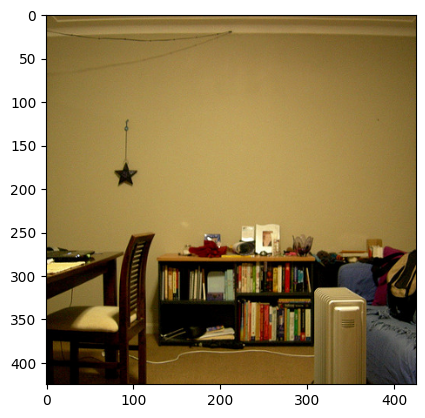

In [18]:
with torch.no_grad():
    caption, _ = model(testImg, temperature)
print(caption)
plt.imshow(testImg)
plt.show()